# Hanoi Weather Data - Data Processing

This notebook handles data cleaning, preprocessing, and preparation for feature engineering and modeling.

## Objectives
1. Load and clean the raw weather data
2. Handle missing values and outliers
3. Data type conversions and validation
4. Create base temporal features
5. Data quality checks and validation
6. Export cleaned data for feature engineering

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import os

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 2. Data Loading and Initial Cleaning

In [2]:
# Load raw data
df_raw = pd.read_csv('../data/raw/daily_data.csv')

print("RAW DATA OVERVIEW:")
print(f"Shape: {df_raw.shape}")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")

# Check data types and missing values
print(f"\nDATA QUALITY CHECK:")
print(f"Missing values per column:")
missing_summary = df_raw.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(df_raw)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
else:
    print("No missing values found!")

print(f"\nDuplicate records: {df_raw.duplicated().sum()}")

# Data information
print(f"\nDATA TYPES:")
print(df_raw.info())


RAW DATA OVERVIEW:
Shape: (3654, 33)
Date range: 2015-10-01 to 2025-10-01

DATA QUALITY CHECK:
Missing values per column:
  severerisk: 2654 (72.6%)
  preciptype: 987 (27.0%)

Duplicate records: 0

DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3654 non-null   object 
 1   datetime          3654 non-null   object 
 2   tempmax           3654 non-null   float64
 3   tempmin           3654 non-null   float64
 4   temp              3654 non-null   float64
 5   feelslikemax      3654 non-null   float64
 6   feelslikemin      3654 non-null   float64
 7   feelslike         3654 non-null   float64
 8   dew               3654 non-null   float64
 9   humidity          3654 non-null   float64
 10  precip            3654 non-null   float64
 11  precipprob        3654 non-null   int64  
 12  precipcover       36

### Missing Values Analysis

In [3]:
# preciptype column
print("PRECIPTYPE ANALYSIS:")
print("Value counts:")
print(df_raw['preciptype'].value_counts())
print(f"NaN values: {df_raw['preciptype'].isnull().sum()}")

# Check relationship with precipitation amount
print(f"\nCross-check with precip amount:")
print("When preciptype is NaN:")
no_preciptype = df_raw[df_raw['preciptype'].isnull()]
print(f"  - Average precip: {no_preciptype['precip'].mean():.3f} mm")
print(f"  - Max precip: {no_preciptype['precip'].max():.3f} mm")
print(f"  - Days with precip > 0: {(no_preciptype['precip'] > 0).sum()}")

print("When preciptype is 'rain':")
has_preciptype = df_raw[df_raw['preciptype'].notna()]
print(f"  - Average precip: {has_preciptype['precip'].mean():.3f} mm")
print(f"  - Min precip: {has_preciptype['precip'].min():.3f} mm")

df = df_raw.copy()

# Fill NaN with 'none' (no precipitation)
df['preciptype'] = df['preciptype'].fillna('none')

print(f"\nAFTER PROCESSING:")
print("Preciptype distribution:")
print(df['preciptype'].value_counts())

PRECIPTYPE ANALYSIS:
Value counts:
preciptype
rain    2667
Name: count, dtype: int64
NaN values: 987

Cross-check with precip amount:
When preciptype is NaN:
  - Average precip: 0.000 mm
  - Max precip: 0.000 mm
  - Days with precip > 0: 0
When preciptype is 'rain':
  - Average precip: 7.230 mm
  - Min precip: 0.000 mm

AFTER PROCESSING:
Preciptype distribution:
preciptype
rain    2667
none     987
Name: count, dtype: int64


**`Preciptype` column analysis:**
- Contains only 'rain' values and NaN
- **Key insight**: All NaN values correspond to days with 0mm precipitation
- **Solution**: Fill NaN with 'none' (meaning no precipitation)
- **Validation**: Perfect correlation between NaN preciptype and zero precipitation amount

### Convert datetime columns and Remove low-variance column

In [4]:
# Convert datetime columns
df['datetime'] = pd.to_datetime(df['datetime'])
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])

# Sort chronologically
df = df.sort_values('datetime').reset_index(drop=True)

# Remove low-variance column
low_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
if low_var_cols:
    print(f"\n⚠️ Dropping {len(low_var_cols)} columns with 0 variance or 1 unique value:")
    for col in low_var_cols:
        print(f"  - {col} (unique values: {df[col].nunique()})")
    df = df.drop(columns=low_var_cols)
else:
    print("\n✅ No constant or single-value columns found.")

print(f"\nFEATURE TYPES AFTER CLEANING:")
print(df.info())


⚠️ Dropping 3 columns with 0 variance or 1 unique value:
  - name (unique values: 1)
  - snow (unique values: 1)
  - snowdepth (unique values: 1)

FEATURE TYPES AFTER CLEANING:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          3654 non-null   datetime64[ns]
 1   tempmax           3654 non-null   float64       
 2   tempmin           3654 non-null   float64       
 3   temp              3654 non-null   float64       
 4   feelslikemax      3654 non-null   float64       
 5   feelslikemin      3654 non-null   float64       
 6   feelslike         3654 non-null   float64       
 7   dew               3654 non-null   float64       
 8   humidity          3654 non-null   float64       
 9   precip            3654 non-null   float64       
 10  precipprob        3654 non-null   int64         
 11  precipco

In [5]:
# severerisk column
print(f"Severerisk missing: {df['severerisk'].isnull().sum()}")
if df['severerisk'].isnull().sum() > 0:
    # Fill with 0 (no severe risk) for missing values
    df['severerisk'] = df['severerisk'].fillna(0)

# Check for any remaining missing values
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print(remaining_missing)

Severerisk missing: 2654
Series([], dtype: int64)


## 3. Outlier Detection & Analysis

OUTLIER ANALYSIS BY VARIABLE:
temp           :    3 outliers (  0.1%)
                Valid range: 9.15 to 40.75
tempmax        :    3 outliers (  0.1%)
                Valid range: 10.75 to 46.35
tempmin        :    1 outliers (  0.0%)
                Valid range: 6.00 to 38.00
humidity       :   86 outliers (  2.4%)
                Valid range: 51.21 to 106.71
precip         :  599 outliers ( 16.4%)
                Valid range: -3.81 to 6.35
windspeed      :   43 outliers (  1.2%)
                Valid range: 0.90 to 28.90
sealevelpressure:    1 outliers (  0.0%)
                Valid range: 988.20 to 1033.80
cloudcover     :   44 outliers (  1.2%)
                Valid range: 3.60 to 129.20
visibility     :    0 outliers (  0.0%)


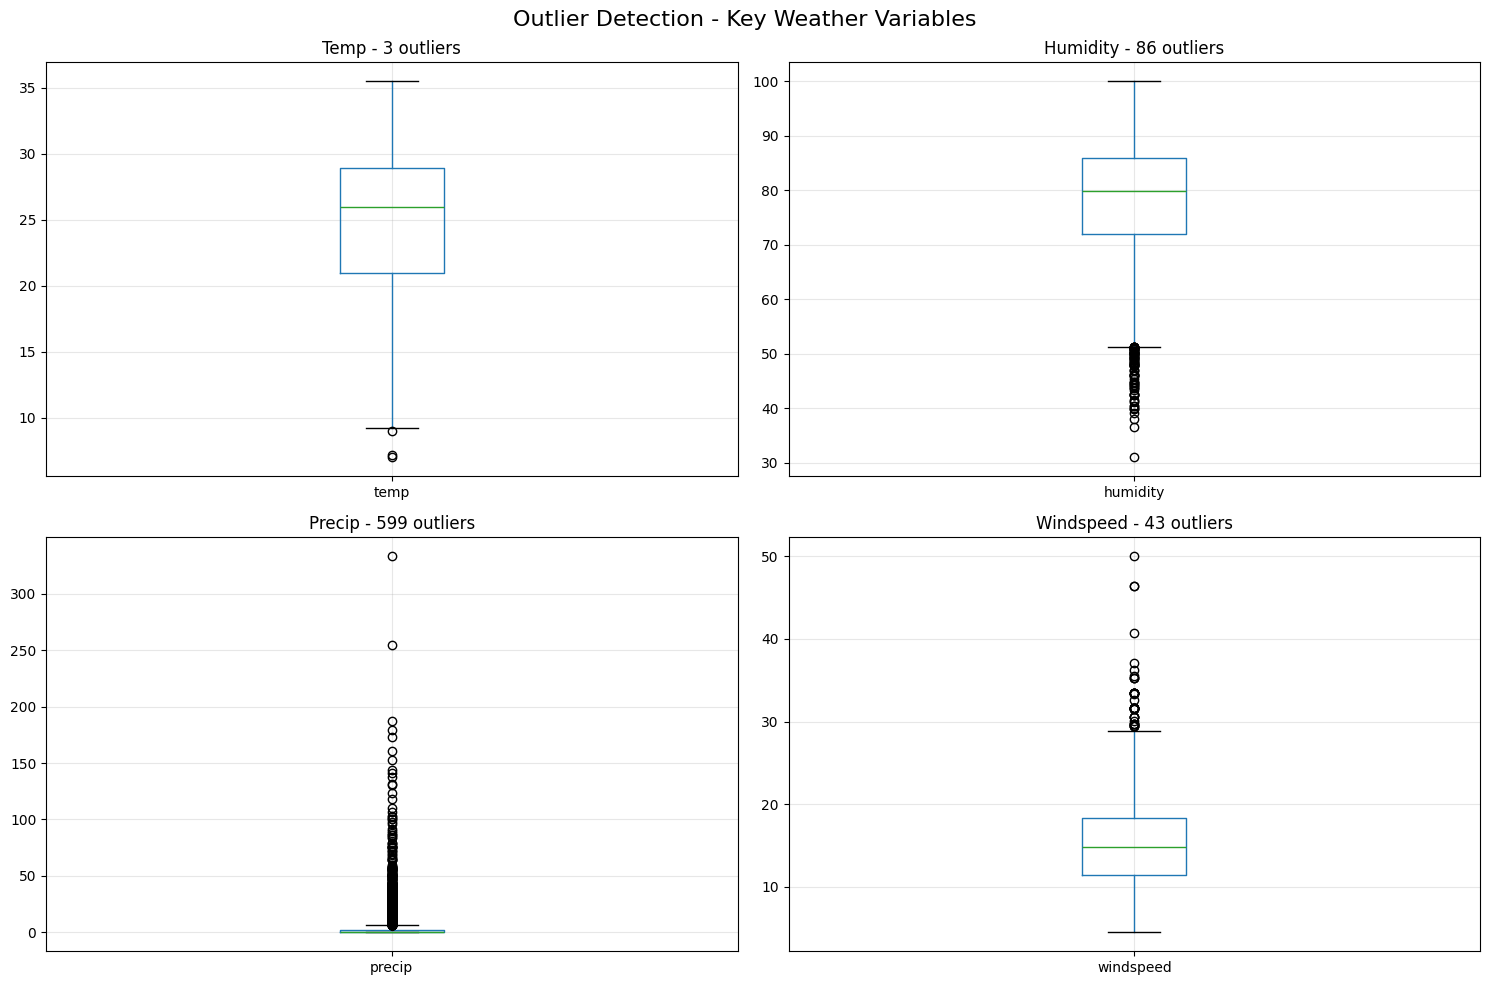

In [6]:
# Define function to detect outliers using IQR method
def detect_outliers_iqr(data, column, factor=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Key numerical columns to check for outliers
numerical_cols = ['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 
                  'windspeed', 'sealevelpressure', 'cloudcover', 'visibility']

outlier_summary = {}

print("OUTLIER ANALYSIS BY VARIABLE:")

for col in numerical_cols:
    if col in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_pct,
            'lower_bound': lower,
            'upper_bound': upper
        }
        
        print(f"{col:15}: {outlier_count:4d} outliers ({outlier_pct:5.1f}%)")
        if outlier_count > 0:
            print(f"                Valid range: {lower:.2f} to {upper:.2f}")

# Visualize outliers for key temperature variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Outlier Detection - Key Weather Variables', fontsize=16)

variables_to_plot = ['temp', 'humidity', 'precip', 'windspeed']
for i, var in enumerate(variables_to_plot):
    if var in df.columns:
        row, col = i // 2, i % 2
        
        # Box plot
        df.boxplot(column=var, ax=axes[row, col])
        axes[row, col].set_title(f'{var.title()} - {outlier_summary[var]["count"]} outliers')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Insights**
- Most weather features are well within physical bounds.
- Temperature and pressure are stable and trustworthy.
- **precip**: Precipitation requires correction — negative values are invalid.
- **humidity**: Humidity and cloudcover may need capping or normalization.
- Temperature and pressure are stable and trustworthy.

In [7]:
# Clip or clean invalid values

df['precip'] = df['precip'].clip(lower=0)
df['humidity'] = df['humidity'].clip(upper=100)
df['cloudcover'] = df['cloudcover'].clip(upper=100)

## 4. Saving Processed Data

In [ ]:
# Define path
processed_path = '../data/processed/daily_data_cleaned.csv'

# Save as csv (recommended)
df.to_csv(processed_path, index=False)

print(f"Cleaned data saved successfully to: {processed_path}")
print(f"Shape: {df.shape}")

Cleaned data saved successfully to: ../data/processed/daily_data_clean.csv
Shape: (3654, 30)
